# Data Extraction

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import opensim as osim
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom import minidom
import pandas as pd
from scipy import signal

### Setup OpenSim and Load Model

In [2]:
# Sample model file
!gdown "1Yx2FnMYRRcass9UEuGeVu1VYtZuzzWC2&confirm=t" # gait2354_simbody.osim

Downloading...
From: https://drive.google.com/uc?id=1Yx2FnMYRRcass9UEuGeVu1VYtZuzzWC2&confirm=t
To: /home/ubuntu/injury_detection/jupyter_notebooks/risk/gait2354_simbody.osim
100%|████████████████████████████████████████| 333k/333k [00:00<00:00, 2.29MB/s]


In [3]:
# Load the model.
gait2354 = osim.Model('gait2354_simbody.osim')
print("Name of the model:", gait2354.getName())

[info] Updating Model file from 20303 to latest format...
Name of the model: 3DGaitModel2354
[info] Loaded model 3DGaitModel2354 from file gait2354_simbody.osim
[warning] Couldn't find file 'sacrum.vtp'.
[warning] Couldn't find file 'pelvis.vtp'.
[warning] Couldn't find file 'l_pelvis.vtp'.
[warning] Couldn't find file 'femur_r.vtp'.
[warning] Couldn't find file 'tibia_r.vtp'.
[warning] Couldn't find file 'fibula.vtp'.
[warning] Couldn't find file 'talus.vtp'.
[warning] Couldn't find file 'foot.vtp'.
[warning] Couldn't find file 'bofoot.vtp'.
[warning] Couldn't find file 'femur_l.vtp'.
[warning] Couldn't find file 'tibia_l.vtp'.
[warning] Couldn't find file 'l_fibula.vtp'.
[warning] Couldn't find file 'l_talus.vtp'.
[warning] Couldn't find file 'l_foot.vtp'.
[warning] Couldn't find file 'l_bofoot.vtp'.
[warning] Couldn't find file 'hat_spine.vtp'.
[warning] Couldn't find file 'hat_jaw.vtp'.
[warning] Couldn't find file 'hat_skull.vtp'.
[warning] Couldn't find file 'hat_ribs.vtp'.
[info

### Joint Angle Extraction and Analysis

In [ ]:
def get_joint_angles(motion_file_path, joints_to_analyze, plot=False):
    if not os.path.exists(motion_file_path):
        raise FileNotFoundError(f"Motion file not found: {motion_file_path}")
    
    # Load the motion file
    table = osim.TimeSeriesTable(motion_file_path)
    
    # Get time vector
    time = np.array(table.getIndependentColumn())
    n_frames = len(time)
    
    # Initialize output structures
    angles = {}
    peaks = {}
    
    for joint in joints_to_analyze:
        try:
            # Get the joint angle column and convert to numpy array
            angle_col = table.getDependentColumn(joint)
            
            # Correct way to convert OpenSim Vector to numpy array
            angle_data = np.zeros(angle_col.size())
            for i in range(angle_col.size()):
                angle_data[i] = angle_col[i]  # Direct indexing works
            
            angles[joint] = angle_data
            peaks[joint] = {
                'max': np.max(angle_data),
                'min': np.min(angle_data)
            }
        except Exception as e:
            print(f"Warning: Could not process joint '{joint}'. Error: {str(e)}")
            angles[joint] = np.full(n_frames, np.nan)
            peaks[joint] = {'max': np.nan, 'min': np.nan}
    
    # Plotting (optional)
    if plot:
        n_joints = len(joints_to_analyze)
        fig, axs = plt.subplots(n_joints, 1, figsize=(10, 3 * n_joints))
        
        # Handle case when only one joint is plotted
        if n_joints == 1:
            axs = [axs]
        
        fig.suptitle('Joint Angles Over Time')
        
        for i, joint in enumerate(joints_to_analyze):
            axs[i].plot(time, angles[joint], label=joint)
            axs[i].set_title(joint)
            axs[i].set_xlabel('Time (s)')
            axs[i].set_ylabel('Angle (rad)')
            axs[i].grid()
            axs[i].legend()
        
        plt.tight_layout()
        plt.show()
    
    return {
        'time': time,
        'angles': angles,
        'peaks': peaks
    }

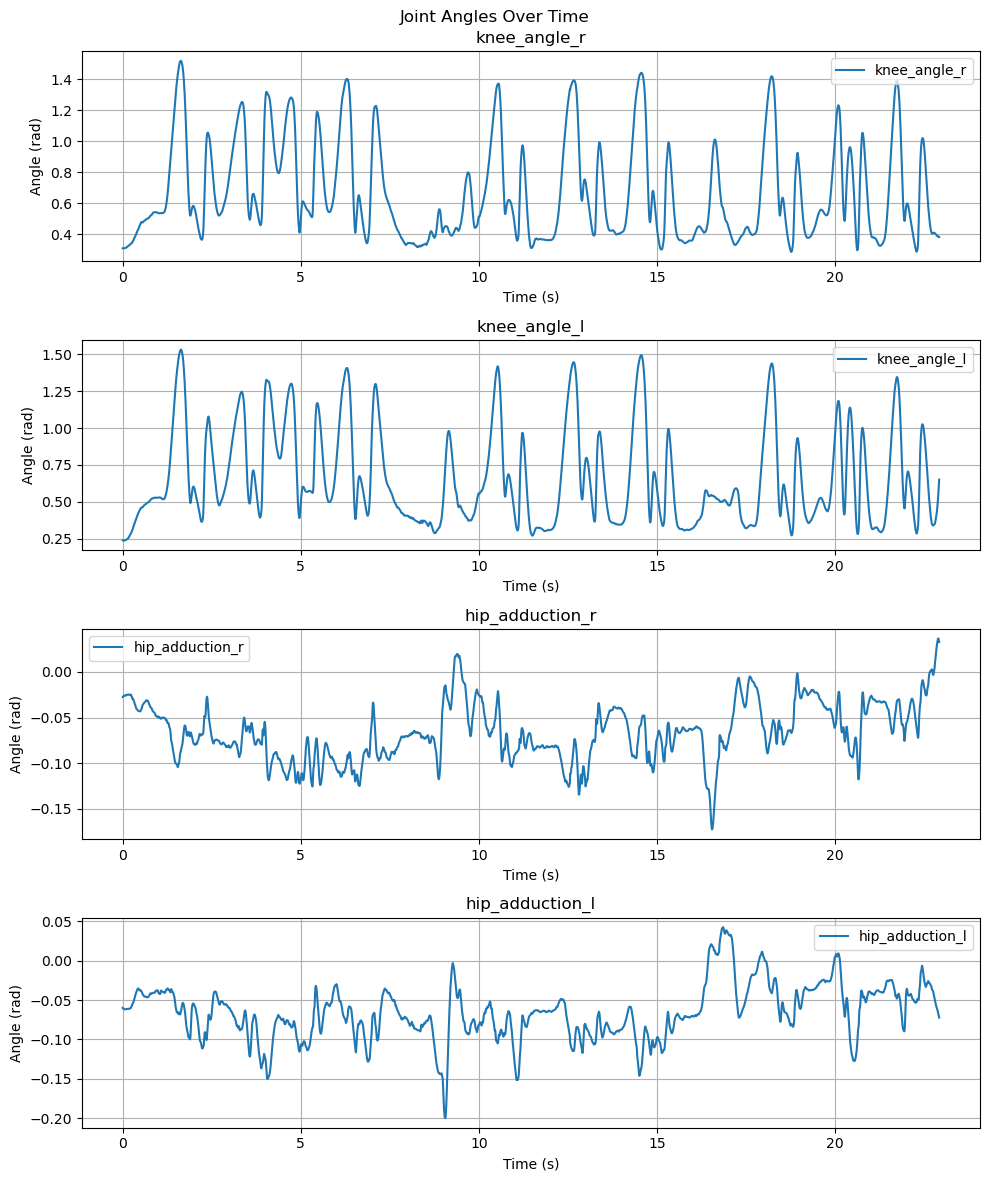

In [5]:
motion_file = '/home/ubuntu/injury_detection/SMPL2AddBiomechanics/models/bsm/sample_motion/01/01_01_ik.mot'
joints = ['knee_angle_r', 'knee_angle_l', 'hip_adduction_r', 'hip_adduction_l']

# Get joint angles with plotting
data = get_joint_angles(motion_file, joints, plot=True)

# Check for injury risk
if data['peaks']['knee_angle_r']['max'] > 10:
    print(f"ACL risk detected! Max knee valgus: {data['peaks']['knee_angle_r']['max']:.1f}°")

In [6]:
def check_joint_angles(joint_data, body_weight=None):
    """
    Check joint angles against injury risk thresholds.
    
    Args:
        joint_data (dict): Output from get_joint_angles() containing:
            - 'time': Time vector
            - 'angles': Dictionary of joint angles (in radians)
            - 'peaks': Dictionary of max/min angles
        body_weight (float): Optional body weight in kg for force-dependent rules
    
    Returns:
        dict: Dictionary of detected risks with details
    """
    # Convert all angles from radians to degrees
    angles_deg = {joint: np.rad2deg(data) for joint, data in joint_data['angles'].items()}
    peaks_deg = {}
    for joint in joint_data['peaks']:
        peaks_deg[joint] = {
            'max': np.rad2deg(joint_data['peaks'][joint]['max']),
            'min': np.rad2deg(joint_data['peaks'][joint]['min'])
        }
    
    risks = {}
    
    # Knee Joint Checks
    if 'knee_angle_r' in angles_deg or 'knee_angle_l' in angles_deg:
        for side in ['r', 'l']:
            joint = f'knee_angle_{side}'
            if joint in angles_deg:
                # Valgus check (positive values = valgus)
                max_valgus = peaks_deg[joint]['max']
                if max_valgus > 10:
                    risks[f'{joint}_valgus'] = {
                        'type': 'ACL injury risk',
                        'value': f'{max_valgus:.1f}°',
                        'threshold': '>10°',
                        'rationale': 'Excessive valgus increases ACL strain due to lateral shear forces'
                    }
                
                # Flexion check during landing (assuming landing phase is when flexion is minimum)
                min_flexion = peaks_deg[joint]['min']
                if min_flexion < 30:
                    risks[f'{joint}_flexion'] = {
                        'type': 'Patellar tendon stress',
                        'value': f'{min_flexion:.1f}°',
                        'threshold': '<30°',
                        'rationale': 'Insufficient flexion during deceleration increases patellar tendon stress'
                    }
                
                # Hyperextension check
                if peaks_deg[joint]['min'] < -5:
                    risks[f'{joint}_hyperextension'] = {
                        'type': 'PCL stress',
                        'value': f'{peaks_deg[joint]["min"]:.1f}°',
                        'threshold': '>5° hyperextension',
                        'rationale': 'Hyperextension stresses posterior cruciate ligament'
                    }
    
    # Hip Joint Checks
    for side in ['r', 'l']:
        adduction_joint = f'hip_adduction_{side}'
        rotation_joint = f'hip_rotation_{side}'  # Note: May need to adjust based on your actual column names
        
        if adduction_joint in angles_deg:
            # Hip flexion check (assuming adduction angles are available)
            max_flexion = peaks_deg[adduction_joint]['max']
            if max_flexion > 90:
                risks[f'hip_flexion_{side}'] = {
                    'type': 'Lumbar spine compression risk',
                    'value': f'{max_flexion:.1f}°',
                    'threshold': '>90°',
                    'rationale': 'Deep flexion with load risks lumbar spine compression',
                    'note': 'Requires torque >2 Nm/kg to confirm risk'  # Would need torque data
                }
        
        if rotation_joint in angles_deg:
            max_rotation = max(abs(peaks_deg[rotation_joint]['max']), 
                              abs(peaks_deg[rotation_joint]['min']))
            if max_rotation > 25:
                risks[f'hip_rotation_{side}'] = {
                    'type': 'Labral tear risk',
                    'value': f'{max_rotation:.1f}°',
                    'threshold': '>25°',
                    'rationale': 'Excessive rotation during pivoting risks labral tears'
                }
    
    # Shoulder Joint Checks (if data available)
    for side in ['r', 'l']:
        rotation_joint = f'shoulder_rotation_{side}'
        abduction_joint = f'shoulder_abduction_{side}'
        
        if rotation_joint in angles_deg:
            max_ext_rotation = peaks_deg[rotation_joint]['max']
            if max_ext_rotation > 120:
                risks[f'shoulder_rotation_{side}'] = {
                    'type': 'Rotator cuff impingement',
                    'value': f'{max_ext_rotation:.1f}°',
                    'threshold': '>120°',
                    'rationale': 'Excessive external rotation during overhead throwing risks impingement'
                }
        
        if abduction_joint in angles_deg:
            max_abduction = peaks_deg[abduction_joint]['max']
            if max_abduction > 90:
                # Would need velocity data for full assessment
                risks[f'shoulder_abduction_{side}'] = {
                    'type': 'Supraspinatus tendon strain',
                    'value': f'{max_abduction:.1f}°',
                    'threshold': '>90°',
                    'rationale': 'High abduction with rapid acceleration stresses supraspinatus',
                    'note': 'Requires velocity >300°/s to confirm risk'
                }
    
    # Spine Checks (if data available)
    if 'lumbar_flexion' in angles_deg:
        max_flexion = peaks_deg['lumbar_flexion']['max']
        if max_flexion > 45:
            risks['lumbar_flexion'] = {
                'type': 'Disc herniation risk',
                'value': f'{max_flexion:.1f}°',
                'threshold': '>45°',
                'rationale': 'Excessive flexion with load increases disc herniation risk',
                'note': 'Requires asymmetric load >15% body weight to confirm risk'
            }
    
    return risks

In [7]:
# First get your joint angles (in radians)
joint_data = get_joint_angles(motion_file, joints, plot=False)

# Then check for injury risks
injury_risks = check_joint_angles(joint_data, body_weight=70) 

# Print the results
for risk, details in injury_risks.items():
    print(f"Risk detected: {details['type']}")
    print(f"  Joint: {risk}")
    print(f"  Measured value: {details['value']} (threshold: {details['threshold']})")
    print(f"  Rationale: {details['rationale']}")
    if 'note' in details:
        print(f"  Note: {details['note']}")
    print()

Risk detected: ACL injury risk
  Joint: knee_angle_r_valgus
  Measured value: 87.0° (threshold: >10°)
  Rationale: Excessive valgus increases ACL strain due to lateral shear forces

Risk detected: Patellar tendon stress
  Joint: knee_angle_r_flexion
  Measured value: 16.4° (threshold: <30°)
  Rationale: Insufficient flexion during deceleration increases patellar tendon stress

Risk detected: ACL injury risk
  Joint: knee_angle_l_valgus
  Measured value: 87.8° (threshold: >10°)
  Rationale: Excessive valgus increases ACL strain due to lateral shear forces

Risk detected: Patellar tendon stress
  Joint: knee_angle_l_flexion
  Measured value: 13.5° (threshold: <30°)
  Rationale: Insufficient flexion during deceleration increases patellar tendon stress



## Joint Force and Torque Analysis

In [52]:
def generate_complete_grf(ik_table, body_weight, foot_marker='foot_r_z'):
    """Generate full GRF data with all 18 components for OpenSim"""
    time = ik_table.getIndependentColumn()
    grf_data = osim.TimeSeriesTable()
    
    # All required GRF components
    grf_components = [
        "ground_force_vx", "ground_force_vy", "ground_force_vz",
        "ground_force_px", "ground_force_py", "ground_force_pz",
        "1_ground_force_vx", "1_ground_force_vy", "1_ground_force_vz",
        "1_ground_force_px", "1_ground_force_py", "1_ground_force_pz",
        "ground_torque_x", "ground_torque_y", "ground_torque_z",
        "1_ground_torque_x", "1_ground_torque_y", "1_ground_torque_z"
    ]
    grf_data.setColumnLabels(grf_components)
    
    # 1. Detect contact periods automatically
    try:
        foot_z = ik_table.getDependentColumn(foot_marker).to_numpy()
        print("foot_z:", foot_z)  # Debugging line
        contact_threshold = np.percentile(foot_z, 10) + 0.02  # 2cm above lowest
        print("contact_threshold:", contact_threshold)  # Debugging line
        in_contact = foot_z < contact_threshold
        print("Contact periods:", np.sum(in_contact))  # Debugging line
    except Exception as e:
        print(f"Error with foot marker: {e}. Using time-based contact estimation")
        in_contact = np.zeros(len(time), dtype=bool)
        for i, t in enumerate(time):
            if 0.4 <= (t % 1.0) <= 0.8:  # For cyclic motion
                in_contact[i] = True
        print("Using time-based contact estimation. Contact periods:", np.sum(in_contact))  # Debugging line
    
    # 2. Generate biomechanically realistic GRF patterns
    for i, t in enumerate(time):
        if in_contact[i]:
            # Calculate normalized contact progress (0-1)
            contact_start = max(0, i - np.argmax(in_contact[:i][::-1])) if in_contact[i] else 0
            contact_end = min(len(time)-1, i + np.argmax(in_contact[i:])) if in_contact[i] else 0
            
            # Prevent division by zero
            if contact_end != contact_start:
                contact_progress = (i - contact_start) / (contact_end - contact_start)
            else:
                contact_progress = 0.0  # Or use a default value like 0.0
            
            # Vertical force (double peak)
            vy = body_weight * (1.5 * np.exp(-12.5*(contact_progress-0.25)**2) + 
                               1.0 * np.exp(-12.5*(contact_progress-0.75)**2))
            
            # Horizontal forces
            vx = body_weight * 0.15 * np.sin(2*np.pi*contact_progress)
            vz = body_weight * (-0.3 * np.exp(-20*(contact_progress-0.3)**2) + 
                               0.25 * np.exp(-20*(contact_progress-0.7)**2))
            
            # Center of Pressure trajectory (heel to toe)
            cop_x = 0.1 * np.sin(np.pi*contact_progress)  # Mediolateral
            cop_y = 0.05 + 0.15*contact_progress         # Anteroposterior
            cop_z = 0.0
            
            # Torques (small physiological values)
            tx = body_weight * 0.01 * np.sin(2*np.pi*contact_progress)
            ty = body_weight * 0.005 * (1 - 2*contact_progress)
            tz = body_weight * 0.01 * np.cos(2*np.pi*contact_progress)
            
            # Calculate the "1" set of forces and torques by applying slight offsets
            # Adjust the "1" set to be slightly different from the original, representing a second contact source
            vy_1 = vy * 0.9
            vx_1 = vx * 1.1
            vz_1 = vz * 1.1
            cop_x_1 = cop_x * 1.05
            cop_y_1 = cop_y * 0.95
            cop_z_1 = cop_z * 1.05
            tx_1 = tx * 0.9
            ty_1 = ty * 1.1
            tz_1 = tz * 0.95
            
            # Ensure all 18 columns are filled
            row_values = [
                vx, vy, vz, cop_x, cop_y, cop_z,   # Forces and COP (ground)
                vx_1, vy_1, vz_1, cop_x_1, cop_y_1, cop_z_1,  # Forces and COP (1_ground)
                tx, ty, tz, tx_1, ty_1, tz_1        # Torques (ground and 1_ground)
            ]
        else:
            # Swing phase - minimal residual forces (ensure all columns are filled)
            row_values = [
                body_weight * 0.01 * np.random.randn(),  # ground_force_vx
                body_weight * 0.02,                      # ground_force_vy
                body_weight * 0.01 * np.random.randn(),  # ground_force_vz
                0.0, 0.0, 0.0,                          # ground_force_px, py, pz
                body_weight * 0.01 * np.random.randn(),  # 1_ground_force_vx
                body_weight * 0.02,                      # 1_ground_force_vy
                body_weight * 0.01 * np.random.randn(),  # 1_ground_force_vz
                0.0, 0.0, 0.0,                          # 1_ground_force_px, py, pz
                0.0, 0.0, 0.0,                          # ground_torque_x, y, z
                0.0, 0.0, 0.0                           # 1_ground_torque_x, y, z
            ]
            
        # Ensure no NaN values
        row_values = [0.0 if np.isnan(x) else x for x in row_values]
        grf_data.appendRow(t, osim.RowVector(row_values))
    
    return grf_data

file_path = os.path.abspath("/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot")
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

model_path = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim"

# Usage with your existing workflow
model = osim.Model(model_path)
body_weight = 75 * 9.81  # Use actual subject weight or calculated from model
ik_table = osim.TimeSeriesTable(file_path)

# Usage with automatic contact detection
complete_grf = generate_complete_grf(ik_table, body_weight)

# Save and analyze
output_path = "motionConfig/improved_grf.sto"
osim.STOFileAdapter().write(complete_grf, output_path)


[info] Updating Model file from 40000 to latest format...
Error with foot marker: std::exception in 'OpenSim::DataTable_< double,double >::VectorView OpenSim::DataTable_< double,double >::getDependentColumn(std::string const &) const': Key 'foot_r_z' not found.
	Thrown at AbstractDataTable.cpp:159 in getColumnIndex().. Using time-based contact estimation
Using time-based contact estimation. Contact periods: 1102
[info] Loaded model FullBodyModel_MuscleActuatedLowerLimb_TorqueActuatedUpperBody from file /home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim
[warning] Couldn't find file 'sacrum.vtp'.
[warning] Couldn't find file 'r_femur.vtp'.
[warning] Couldn't find file 'r_fibula.vtp'.
[warning] Couldn't find file 'r_patella.vtp'.
[warning] Couldn't find file 'r_talus.vtp'.
[warning] Couldn't find file 'r_foot.vtp'.
[warning] Couldn't find file 'r_bofoot.vtp'.
[warning] Couldn't find file 'l_femur.vtp'.
[warning] Couldn't find file 'l_fibula.vtp'.
[warning] Couldn't

In [ ]:
# Specific sport cases

# # Running pattern
# complete_grf = generate_complete_grf(
#     ik_table, 
#     body_weight,
#     contact_params={
#         'peak_vertical': 2.5,  # xBW
#         'braking_force': 0.3,  # xBW
#         'propulsion_force': 0.25  # xBW
#     }
# )

# # Jumping pattern
# jump_grf = generate_complete_grf(
#     ik_table,
#     body_weight,
#     contact_params={
#         'peak_vertical': 4.0,
#         'shape': 'single_peak'  # Instead of double peak
#     }
# )

In [28]:
def create_external_loads_file(output_path, grf_mot_file, body_mapping=None):
    """
    Create an ExternalLoads XML file for OpenSim.
    
    Args:
        output_path (str): Path to save the XML file
        grf_mot_file (str): Path to the ground reaction forces .mot file
        body_mapping (dict): Mapping of force names to body segments
            Default: {'right': 'calcn_r', 'left': 'calcn_l'}
    
    Returns:
        str: Path to the created file
    """
    if body_mapping is None:
        body_mapping = {'right': 'calcn_r', 'left': 'calcn_l'}
    
    # Create root element
    opensim_doc = Element("OpenSimDocument", Version="20302")
    ext_loads = SubElement(opensim_doc, "ExternalLoads", name="GRF")
    objects = SubElement(ext_loads, "objects")
    
    # Create force elements
    for side in ['right', 'left']:
        force = SubElement(objects, "ExternalForce", name=side)
        SubElement(force, "isDisabled").text = "false"
        SubElement(force, "applied_to_body").text = body_mapping[side]
        SubElement(force, "force_expressed_in_body").text = "ground"
        SubElement(force, "point_expressed_in_body").text = "ground"
        
        prefix = "1_" if side == "left" else ""
        SubElement(force, "force_identifier").text = f"{prefix}ground_force_v"
        SubElement(force, "point_identifier").text = f"{prefix}ground_force_p"
        SubElement(force, "torque_identifier").text = f"{prefix}ground_torque_"
        SubElement(force, "data_source_name").text = "Unassigned"
    
    SubElement(ext_loads, "groups")
    SubElement(ext_loads, "datafile").text = os.path.basename(grf_mot_file)
    
    # Create pretty XML
    rough_xml = tostring(opensim_doc, 'utf-8')
    parsed_xml = minidom.parseString(rough_xml)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")
    
    # Write to file
    with open(output_path, 'w') as f:
        f.write(pretty_xml)
    
    print(f"Created ExternalLoads file: {output_path}")
    return output_path

In [32]:

def create_inverse_dynamics_setup(output_dir, setup_name, model_file, 
                                coordinates_file, grf_mot_file,
                                time_range=(0.4, 1.6), lowpass_cutoff=6.0):
    """
    Create a complete Inverse Dynamics pipeline (both external loads and setup files).
    
    Args:
        output_dir (str): Directory to save all files
        setup_name (str): Base name for files (e.g., 'subject01_walk1')
        model_file (str): Path to .osim model file
        coordinates_file (str): Path to coordinate data file (.mot or .sto)
        grf_mot_file (str): Path to ground reaction forces .mot file
        time_range (tuple): Start and end time (s)
        lowpass_cutoff (float): Filter cutoff frequency (Hz)
    
    Returns:
        str: Path to the created setup file
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Create external loads file
    ext_loads_file = os.path.join(output_dir, f"{setup_name}_grf.xml")
    create_external_loads_file(
        ext_loads_file,
        grf_mot_file=grf_mot_file
    )
    
    # Create inverse dynamics setup file
    setup_file = os.path.join(output_dir, f"{setup_name}_Setup_InverseDynamics.xml")
    
    opensim_doc = Element("OpenSimDocument", Version="20302")
    id_tool = SubElement(opensim_doc, "InverseDynamicsTool", name=setup_name)
    
    # Add elements to setup file
    SubElement(id_tool, "results_directory").text = os.path.join(output_dir, "ResultsInverseDynamics")
    SubElement(id_tool, "input_directory").text = output_dir
    SubElement(id_tool, "model_file").text = os.path.basename(model_file)
    SubElement(id_tool, "time_range").text = f"{time_range[0]:.8f} {time_range[1]:.8f}"
    SubElement(id_tool, "forces_to_exclude").text = "Muscles"
    SubElement(id_tool, "external_loads_file").text = os.path.basename(ext_loads_file)
    SubElement(id_tool, "coordinates_file").text = os.path.basename(coordinates_file)
    SubElement(id_tool, "lowpass_cutoff_frequency_for_coordinates").text = f"{lowpass_cutoff:.8f}"
    SubElement(id_tool, "output_gen_force_file").text = "inverse_dynamics.sto"
    
    # Create pretty XML
    rough_xml = tostring(opensim_doc, 'utf-8')
    parsed_xml = minidom.parseString(rough_xml)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")
    
    # Write to file
    with open(setup_file, 'w') as f:
        f.write(pretty_xml)
    
    print(f"Created Inverse Dynamics setup file: {setup_file}")
    return setup_file

# Configuration
output_dir = "motionConfig"
setup_name = "0101"

# Input files (these should exist)
model_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim"
coordinates_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot"
grf_mot_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/improved_grf.sto"

# Generate the complete pipeline
setup_file = create_inverse_dynamics_setup(
    output_dir=output_dir,
    setup_name=setup_name,
    model_file=model_file,
    coordinates_file=coordinates_file,
    grf_mot_file=grf_mot_file,
    time_range=(0.4, 1.6),
    lowpass_cutoff=6.0
)

print(f"\nPipeline ready. Use this setup file for Inverse Dynamics: {setup_file}")

Created ExternalLoads file: motionConfig/0101_grf.xml
Created Inverse Dynamics setup file: motionConfig/0101_Setup_InverseDynamics.xml

Pipeline ready. Use this setup file for Inverse Dynamics: motionConfig/0101_Setup_InverseDynamics.xml


In [33]:
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
os.environ['QT_DEBUG_PLUGINS'] = '0'

In [34]:
def plot_joint_loads(time, forces, torques):
    """
    Plot joint forces and torques over time.
    
    Parameters:
    - time (array-like): Time array.
    - forces (dict): Dictionary of forces, where keys are joint names and values are the force data.
    - torques (dict): Dictionary of torques, where keys are joint names and values are the torque data.
    """
    
    # Create figure for joint forces and torques
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot forces
    axs[0].set_title('Joint Forces over Time')
    for joint, force in forces.items():
        axs[0].plot(time, force, label=joint)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Force (N)')
    axs[0].legend(loc='best')

    # Plot torques
    axs[1].set_title('Joint Torques over Time')
    for joint, torque in torques.items():
        axs[1].plot(time, torque, label=joint)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Torque (Nm)')
    axs[1].legend(loc='best')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [35]:
def extract_joint_forces_torques(setup_file_path, plot=False):
    """
    Run inverse dynamics and extract joint forces and torques.
    """
    print(f"Extracting joint forces and torques from setup file: {setup_file_path}")
    if not os.path.exists(setup_file_path):
        raise FileNotFoundError(f"Setup file not found: {setup_file_path}")
    
    setup_dir = os.path.dirname(setup_file_path)
    
    print("Running Inverse Dynamics...")
    
    # Load tool and verify files
    id_tool = osim.InverseDynamicsTool(setup_file_path)
    
    # Verify model file
    model_file = os.path.abspath(os.path.join(setup_dir, id_tool.getModelFileName()))
    if not os.path.exists(model_file):
        raise FileNotFoundError(f"Model file not found: {model_file}")
    id_tool.setModelFileName(model_file)
    
    # Verify coordinates file
    coords_file = os.path.abspath(os.path.join(setup_dir, id_tool.getCoordinatesFileName()))
    if not os.path.exists(coords_file):
        raise FileNotFoundError(f"Coordinates file not found: {coords_file}")
    id_tool.setCoordinatesFileName(coords_file)
    
    # Handle GRF data carefully
    grf_mot_file = os.path.abspath(os.path.join(setup_dir, "improved_grf.sto"))
    ext_loads_file = os.path.abspath(os.path.join(setup_dir, id_tool.getExternalLoadsFileName()))
    
    if not os.path.exists(grf_mot_file):
        raise FileNotFoundError(f"GRF data file not found: {grf_mot_file}")
    
    # Verify or recreate external loads file
    if not os.path.exists(ext_loads_file):
        print("Creating new external loads file...")
        create_external_loads_file(ext_loads_file, grf_mot_file)
    
    # Verify the GRF file has required columns
    try:
        grf_table = osim.TimeSeriesTable(grf_mot_file)
        required_columns = [
            'ground_force_v', 'ground_force_p', 'ground_torque_',
            '1_ground_force_v', '1_ground_force_p', '1_ground_torque_'
        ]
        missing = [col for col in required_columns if not any(col in label for label in grf_table.getColumnLabels())]
        if missing:
            raise ValueError(f"GRF file missing required columns: {missing}")
    except Exception as e:
        raise RuntimeError(f"Invalid GRF data: {str(e)}")
    
    id_tool.setExternalLoadsFileName(ext_loads_file)
    
    # Set results directory
    results_dir = os.path.abspath(os.path.join(setup_dir, "ResultsInverseDynamics"))
    os.makedirs(results_dir, exist_ok=True)
    id_tool.setResultsDir(results_dir)
    
    # Run the tool
    print("Running Inverse Dynamics...")
    try:
        if not id_tool.run():
            raise RuntimeError("Inverse Dynamics computation failed")
    except Exception as e:
        raise RuntimeError(f"Inverse Dynamics failed: {str(e)}")
    
    # Process results
    output_file = os.path.join(results_dir, id_tool.getOutputGenForceFileName())
    if not os.path.exists(output_file):
        raise FileNotFoundError(f"Results file not found: {output_file}")
    
    print("Inverse Dynamics completed successfully.")
    table = osim.TimeSeriesTable(output_file)
    time = np.array(table.getIndependentColumn())
    
    forces = {}
    torques = {}
    peaks = {'forces': {}, 'torques': {}}
    
    for label in table.getColumnLabels():
        data = np.array(table.getDependentColumn(label)).flatten()
        if '_force' in label:
            forces[label.replace('_force', '')] = data
        elif '_moment' in label:
            torques[label.replace('_moment', '')] = data
    
    if plot:
        plot_joint_loads(time, forces, torques)
    
    return {
        'time': time,
        'forces': forces,
        'torques': torques,
        'peaks': {
            'forces': {k: {'max': np.max(v), 'min': np.min(v)} for k,v in forces.items()},
            'torques': {k: {'max': np.max(v), 'min': np.min(v)} for k,v in torques.items()}
        }
    }

In [2]:
# unable to load in notebook environment, could run at joint_force_and_torque.py

# setup_file = 'motionConfig/0101_Setup_InverseDynamics.xml'
# load_data = extract_joint_forces_torques(setup_file)

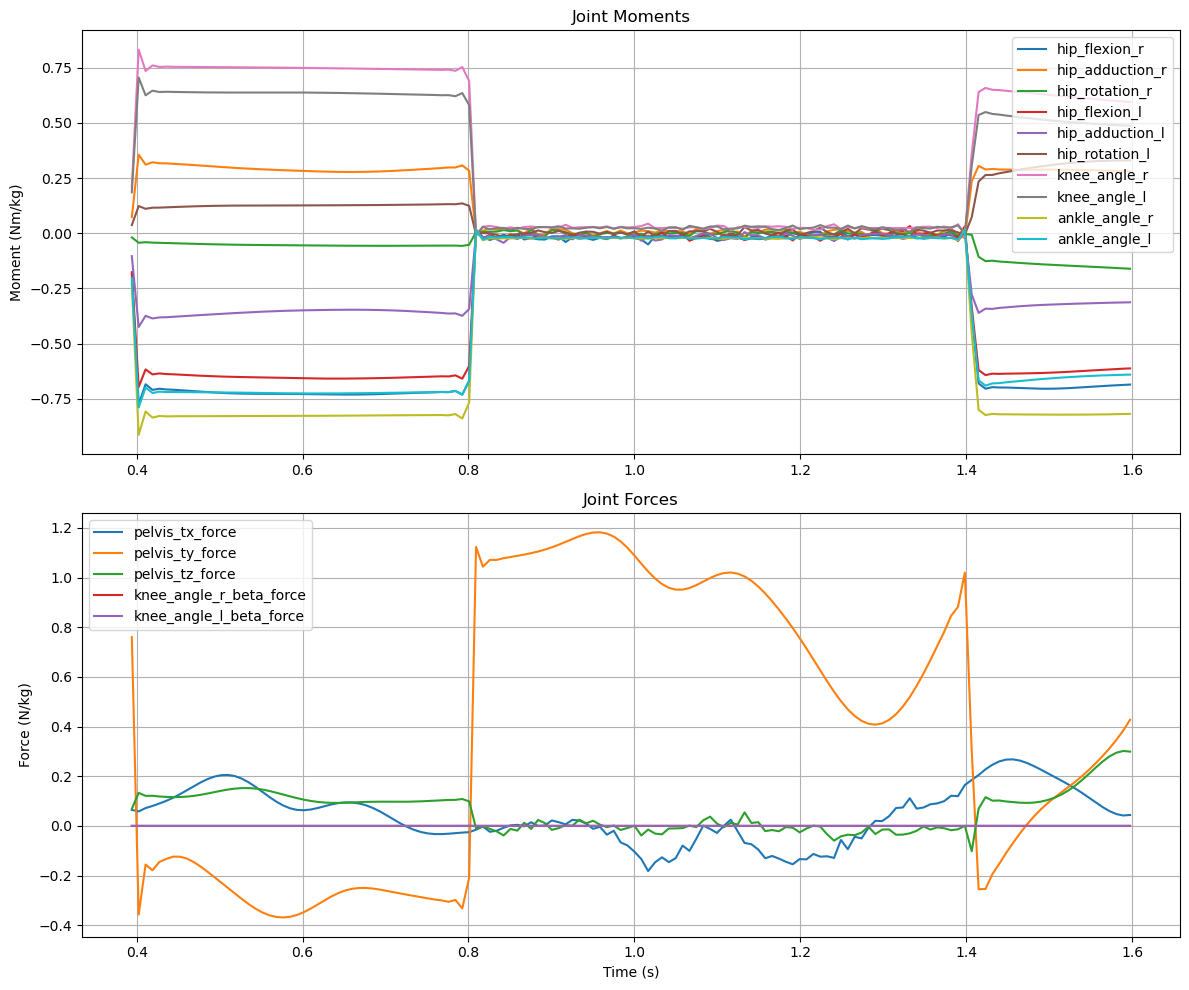

Peak Moments (Nm/kg):
hip_flexion_r: max=0.03, min=-0.77
hip_adduction_r: max=0.36, min=-0.02
hip_rotation_r: max=0.02, min=-0.16
hip_flexion_l: max=0.03, min=-0.70
hip_adduction_l: max=0.00, min=-0.42
hip_rotation_l: max=0.33, min=-0.02
knee_angle_r: max=0.83, min=-0.01
knee_angle_l: max=0.70, min=-0.01
ankle_angle_r: max=0.02, min=-0.91
ankle_angle_l: max=0.01, min=-0.79

Identified Risks:


In [53]:
def analyze_joint_loads(sto_file_path, body_weight=None, plot=True):
    """
    Analyze joint moments and forces from inverse dynamics results.
    """
    # Load the STO file
    table = osim.TimeSeriesTable(sto_file_path)
    time = np.array(table.getIndependentColumn())
    
    # Initialize data structures
    moments = {}
    forces = {}
    
    # Categorize data - CORRECTED DATA EXTRACTION
    for label in table.getColumnLabels():
        # Correct way to get data from OpenSim table
        col = table.getDependentColumn(label)
        data = np.array([col[i] for i in range(col.size())])  # Use indexing
        
        if '_moment' in label:
            moments[label.replace('_moment', '')] = data
        elif '_force' in label:
            forces[label] = data
    
    # Normalize by body weight if provided
    if body_weight:
        bw_norm = body_weight * 9.81  # Convert kg to N
        moments = {k: v/bw_norm for k,v in moments.items()}
        forces = {k: v/bw_norm for k,v in forces.items()}
    
    # Find peak values
    def get_peaks(data_dict):
        return {
            joint: {
                'max': np.max(values),
                'min': np.min(values),
                'mean': np.mean(values),
                'std': np.std(values)
            }
            for joint, values in data_dict.items()
        }
    
    peak_moments = get_peaks(moments)
    peak_forces = get_peaks(forces)
    
    # Injury risk assessment
    def assess_risks(peaks):
        risks = {}
        # Knee joint
        if 'knee_angle_r' in peaks:
            if peaks['knee_angle_r']['max'] > 1.5:  # 1.5 Nm/kg
                risks['knee_r_extension'] = {
                    'value': peaks['knee_angle_r']['max'],
                    'threshold': '>1.5 Nm/kg',
                    'risk': 'ACL injury risk'
                }
        
        # Hip joint
        if 'hip_flexion_r' in peaks:
            if peaks['hip_flexion_r']['max'] > 2.0:  # 2.0 Nm/kg
                risks['hip_r_flexion'] = {
                    'value': peaks['hip_flexion_r']['max'],
                    'threshold': '>2.0 Nm/kg',
                    'risk': 'Hip flexor strain risk'
                }
                
        return risks
    
    risks = assess_risks(peak_moments)
    
    # Plotting
    if plot:
        plot_joint_loads(time, moments, forces, body_weight)
    
    return {
        'time': time,
        'moments': moments,
        'forces': forces,
        'peaks': {
            'moments': peak_moments,
            'forces': peak_forces
        },
        'risks': risks
    }

def plot_joint_loads(time, moments, forces, body_weight=None):
    """Plot joint loads"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot moments
    for joint, data in moments.items():
        if any(x in joint for x in ['hip', 'knee', 'ankle']):  # Focus on lower extremity
            ax1.plot(time, data, label=joint)
    ax1.set_title('Joint Moments')
    ax1.set_ylabel('Moment (Nm/kg)' if body_weight else 'Moment (Nm)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot forces
    for joint, data in forces.items():
        ax2.plot(time, data, label=joint)
    ax2.set_title('Joint Forces')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Force (N/kg)' if body_weight else 'Force (N)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run analysis
results = analyze_joint_loads(
    '/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/ResultsInverseDynamics/inverse_dynamics.sto',
    body_weight=70,
    plot=True
)

# Print results
print("Peak Moments (Nm/kg):")
for joint, vals in results['peaks']['moments'].items():
    if any(x in joint for x in ['hip', 'knee', 'ankle']):
        print(f"{joint}: max={vals['max']:.2f}, min={vals['min']:.2f}")

print("\nIdentified Risks:")
for joint, risk in results['risks'].items():
    print(f"{joint}: {risk['risk']} (value={risk['value']:.2f}, threshold={risk['threshold']})")

In [54]:
def analyze_injury_risks_from_sto(sto_file_path, body_weight):
    """
    Analyze injury risks directly from inverse dynamics .sto file.
    
    Args:
        sto_file_path (str): Path to inverse_dynamics.sto file
        body_weight (float): Body weight in kg
    
    Returns:
        dict: Detected risks with details
    """
    # Load the STO file
    table = osim.TimeSeriesTable(sto_file_path)
    time = np.array(table.getIndependentColumn())
    
    # Extract forces and torques
    forces = {}
    torques = {}
    
    for label in table.getColumnLabels():
        # Convert to numpy array
        data = np.array([table.getDependentColumn(label)[i] for i in range(table.getDependentColumn(label).size())])
        
        if '_force' in label:
            joint = label.replace('_force', '')
            forces[joint] = data
        elif '_moment' in label:
            joint = label.replace('_moment', '')
            torques[joint] = data
    
    # Analyze risks
    risks = {}
    bw_newtons = body_weight * 9.81  # Convert kg to Newtons
    
    # Knee Joint Analysis
    for side in ['r', 'l']:
        # Anterior Shear Force (using pelvis_tz_force as proxy)
        shear_force_key = f'pelvis_tz_force'  # May need adjustment based on your model
        if shear_force_key in forces:
            max_shear = np.max(np.abs(forces[shear_force_key]))
            if max_shear > 0.2 * bw_newtons:
                risks[f'knee_{side}_shear'] = {
                    'type': 'ACL injury risk',
                    'value': f'{max_shear:.1f} N ({max_shear/bw_newtons*100:.1f}% BW)',
                    'threshold': '>20% body weight',
                    'rationale': 'Excessive anterior shear force during deceleration'
                }
        
        # Internal Rotation Torque
        rot_torque_key = f'hip_rotation_{side}_moment'
        if rot_torque_key in torques:
            max_torque = np.max(np.abs(torques[rot_torque_key]))
            if max_torque > 1.5 * body_weight:
                risks[f'knee_{side}_rotation'] = {
                    'type': 'Meniscal stress risk',
                    'value': f'{max_torque:.2f} Nm ({max_torque/body_weight:.2f} Nm/kg)',
                    'threshold': '>1.5 Nm/kg',
                    'rationale': 'High internal rotation torque during cutting'
                }
    
    # Ankle Joint Analysis
    for side in ['r', 'l']:
        # Inversion Moment (using ankle_angle_*_moment as proxy)
        inv_torque_key = f'ankle_angle_{side}_moment'
        if inv_torque_key in torques:
            max_inversion = np.max(np.abs(torques[inv_torque_key]))
            if max_inversion > 0.8 * body_weight:
                risks[f'ankle_{side}_inversion'] = {
                    'type': 'Lateral ligament sprain risk',
                    'value': f'{max_inversion:.2f} Nm ({max_inversion/body_weight:.2f} Nm/kg)',
                    'threshold': '>0.8 Nm/kg',
                    'rationale': 'Excessive inversion moment during lateral movement'
                }
    
    # Shoulder Joint Analysis
    for side in ['r', 'l']:
        # Internal Rotation Torque
        rot_torque_key = f'shoulder_{side}_z_moment'  # Z-component for rotation
        if rot_torque_key in torques:
            max_torque = np.max(np.abs(torques[rot_torque_key]))
            if max_torque > 50:  # Absolute threshold of 50 Nm
                risks[f'shoulder_{side}_rotation'] = {
                    'type': 'Labral tear risk',
                    'value': f'{max_torque:.1f} Nm',
                    'threshold': '>50 Nm',
                    'rationale': 'High internal rotation torque during throwing'
                }
    
    return risks

def print_risk_report(risks):
    """Print formatted risk report"""
    if not risks:
        print("No significant injury risks detected.")
        return
    
    print("\n=== INJURY RISK ASSESSMENT REPORT ===")
    for risk, details in risks.items():
        print(f"\nRisk detected in {risk}:")
        print(f"  Type: {details['type']}")
        print(f"  Measured value: {details['value']}")
        print(f"  Safety threshold: {details['threshold']}")
        print(f"  Rationale: {details['rationale']}")
    print("\n=== END OF REPORT ===")


In [55]:
risks = analyze_injury_risks_from_sto(
    '/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/ResultsInverseDynamics/inverse_dynamics.sto',
    body_weight=75  # in kg
)
print_risk_report(risks)

No significant injury risks detected.


## Muscle Forces and Activations

In [ ]:
# cannot run in notebook environment, could run at muscle_forces_and_activations.py

# # Load the model.
# model = osim.Model('/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim')

# # Define a StaticOptimization object.
# so = osim.StaticOptimization()

# # Set start and end times for the analysis.
# start_time = 0.3
# end_time = 1.5
# so.setStartTime(start_time)
# so.setEndTime(end_time)

# # Create analyze tool for static optimization.
# so_analyze_tool = osim.AnalyzeTool()
# so_analyze_tool.setName("SO")

# # Set model file, motion files and external load file names.
# so_analyze_tool.setModelFilename("/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim")
# so_analyze_tool.setCoordinatesFileName("/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot")
# so_analyze_tool.setExternalLoadsFileName("/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/0101_Setup_InverseDynamics.xml")

# # Add analysis.
# so_analyze_tool.updAnalysisSet().cloneAndAppend(so)

# # Configure analyze tool.
# so_analyze_tool.setReplaceForceSet(False)
# so_analyze_tool.setStartTime(start_time)
# so_analyze_tool.setFinalTime(end_time)

# # Directory where results are stored.
# so_analyze_tool.setResultsDir("SO_Results")

# # Print configuration of analyze tool to a xml file.
# so_analyze_tool.printToXML("SO_AnalyzeTool_setup.xml")

# # Load configuration and run the analyses. 
# so_analyze_tool = osim.AnalyzeTool("SO_AnalyzeTool_setup.xml", True)

# so_analyze_tool.run()

In [5]:
# Load Static Optimization results
forces_file = "SO_Results/SO_StaticOptimization_force.sto"
activations_file = "SO_Results/SO_StaticOptimization_activation.sto"

forces_table = osim.TimeSeriesTable(forces_file)
activations_table = osim.TimeSeriesTable(activations_file)

# Convert to pandas DataFrames
forces_df = pd.DataFrame(forces_table.getMatrix().to_numpy(), 
                        columns=forces_table.getColumnLabels(),
                        index=forces_table.getIndependentColumn())
activations_df = pd.DataFrame(activations_table.getMatrix().to_numpy(),
                            columns=activations_table.getColumnLabels(),
                            index=activations_table.getIndependentColumn())

In [6]:
def calculate_risk_metrics(model, forces_df, activations_df, body_weight):
    """Calculate risk metrics from muscle forces and activations"""
    metrics = {}
    
    # Hamstring to Quadriceps Ratio (HQR)
    hamstrings = ['bflh_r', 'bfsh_r', 'semimem_r', 'semiten_r']
    quads = ['vaslat_r', 'vasmed_r', 'vasint_r', 'recfem_r']

    hq_ratio = activations_df[hamstrings].mean(axis=1) / activations_df[quads].mean(axis=1)
    metrics['hq_ratio'] = hq_ratio
    metrics['hq_risk'] = hq_ratio < 0.6  # Risk threshold
    
    # 2. Gastrocnemius Overload
    gastroc_forces = forces_df[['gaslat_r', 'gasmed_r']].mean(axis=1)
    metrics['gastroc_overload'] = gastroc_forces > (3 * body_weight)
    
    # 3. Gluteus Medius Delay (requires comparison to healthy baseline)
    glu_med = activations_df['glmed1_r']
    metrics['glu_med_activation'] = glu_med
    
    return metrics

In [14]:
model = osim.Model('/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim')

# Method 1: Sum masses of all bodies (most accurate)
total_mass = sum(
    model.getBodySet().get(i).getMass() 
    for i in range(model.getBodySet().getSize()))
body_weight = total_mass * 9.81

print(f"Total model mass: {total_mass:.1f} kg")
print(f"Calculated body weight: {body_weight:.1f} N")

# Method 2: Use a major body segment if sum is incorrect
if total_mass < 30:  # If unrealistically low
    print("\nFalling back to lower body segments...")
    lower_body_mass = sum(
        model.getBodySet().get(name).getMass()
        for name in ['pelvis', 'femur_r', 'femur_l', 'tibia_r', 'tibia_l', 'talus_r', 'talus_l']
        if model.getBodySet().contains(name)
    )
    body_weight = lower_body_mass * 9.81 * 2  # Approximation (lower body ~50% total)
    print(f"Estimated body weight: {body_weight/9.81:.1f} kg")

# Method 3: Manual input (if model masses aren't scaled)
if body_weight/9.81 < 30:
    actual_weight = float(input("Model mass seems incorrect. Enter actual subject weight (kg): "))
    body_weight = actual_weight * 9.81

[info] Updating Model file from 40000 to latest format...
Total model mass: 78.2 kg
Calculated body weight: 767.6 N
[info] Loaded model FullBodyModel_MuscleActuatedLowerLimb_TorqueActuatedUpperBody from file /home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim
[warning] Couldn't find file 'sacrum.vtp'.
[warning] Couldn't find file 'r_femur.vtp'.
[warning] Couldn't find file 'r_fibula.vtp'.
[warning] Couldn't find file 'r_patella.vtp'.
[warning] Couldn't find file 'r_talus.vtp'.
[warning] Couldn't find file 'r_foot.vtp'.
[warning] Couldn't find file 'r_bofoot.vtp'.
[warning] Couldn't find file 'l_femur.vtp'.
[warning] Couldn't find file 'l_fibula.vtp'.
[warning] Couldn't find file 'l_patella.vtp'.
[warning] Couldn't find file 'l_talus.vtp'.
[warning] Couldn't find file 'l_foot.vtp'.
[warning] Couldn't find file 'l_bofoot.vtp'.
[warning] Couldn't find file 'cervical_spine.vtp'.
[warning] Couldn't find file 'lumbar_spine.vtp'.
[warning] Couldn't find file 'thorax.vtp

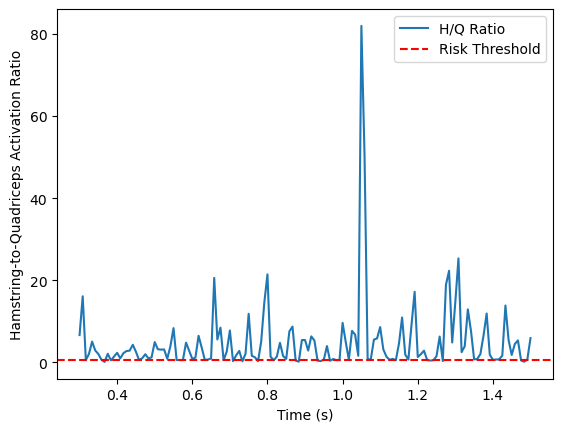

In [16]:
# Now calculate risk metrics with the correct body weight
risk_metrics = calculate_risk_metrics(model, forces_df, activations_df, body_weight)

# Plotting
plt.figure()
risk_metrics['hq_ratio'].plot(label='H/Q Ratio')
plt.axhline(0.6, color='r', linestyle='--', label='Risk Threshold')
plt.ylabel("Hamstring-to-Quadriceps Activation Ratio")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

In [17]:
def detect_activation_delay(activation_curve, threshold=0.1, baseline=None):
    """Detect activation delay relative to baseline or absolute threshold"""
    if baseline is not None:
        # Compare to healthy baseline curve
        delay_samples = np.argmax(activation_curve > threshold) - np.argmax(baseline > threshold)
        return delay_samples * (1/100)  # Assuming 100 Hz data
    else:
        return np.argmax(activation_curve > threshold) * (1/100)


# Example for gluteus medius delay
glu_med_delay = detect_activation_delay(
    risk_metrics['glu_med_activation'].values,
    threshold=0.2
)
print(f"Gluteus medius activation delay: {glu_med_delay*1000:.1f} ms")
if glu_med_delay > 0.05:  # 50 ms
    print("WARNING: Elevated knee valgus risk detected!")

Gluteus medius activation delay: 0.0 ms


Using body weight: 75.0 kg
[info] Updating Model file from 40000 to latest format...

=== RISK ASSESSMENT RESULTS ===

1. HAMSTRING STRAIN RISK (H/Q Ratio <0.6):
   - Occurs 19.3% of movement time
   - WARNING: Elevated risk!

2. ACHILLES TENDON OVERLOAD RISK (>3xBW):
   - Occurs 0.0% of movement time
   - Within safe range
[info] Loaded model FullBodyModel_MuscleActuatedLowerLimb_TorqueActuatedUpperBody from file /home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim
[warning] Couldn't find file 'sacrum.vtp'.
[warning] Couldn't find file 'r_femur.vtp'.
[warning] Couldn't find file 'r_fibula.vtp'.
[warning] Couldn't find file 'r_patella.vtp'.
[warning] Couldn't find file 'r_talus.vtp'.
[warning] Couldn't find file 'r_foot.vtp'.
[warning] Couldn't find file 'r_bofoot.vtp'.
[warning] Couldn't find file 'l_femur.vtp'.
[warning] Couldn't find file 'l_fibula.vtp'.
[warning] Couldn't find file 'l_patella.vtp'.
[warning] Couldn't find file 'l_talus.vtp'.
[warning] Couldn't

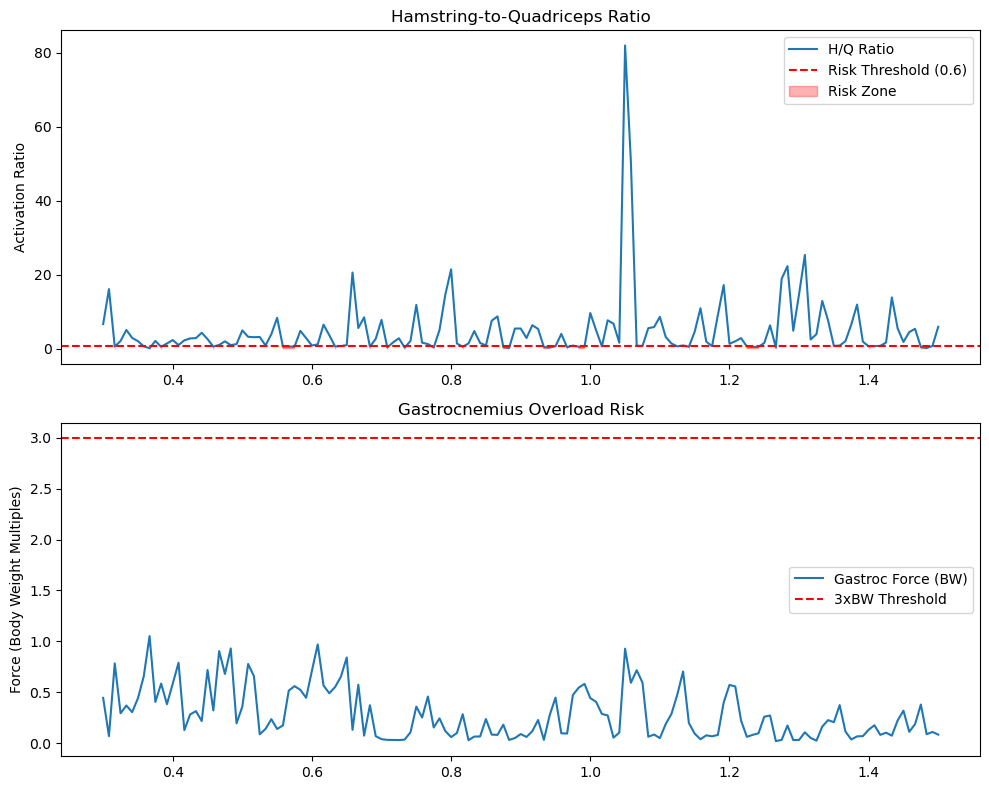


3. GLUTEUS MEDIUS ACTIVATION DELAY:
   - Delay: 0.0 ms (threshold: >50ms = risk)
   - Within normal range


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opensim as osim

def calculate_injury_risks(model_path, forces_file, activations_file, actual_body_weight=None):
    """Integrated injury risk assessment pipeline"""
    # Load model and results
    model = osim.Model(model_path)
    forces_table = osim.TimeSeriesTable(forces_file)
    activations_table = osim.TimeSeriesTable(activations_file)
    
    # Convert to DataFrames
    forces_df = pd.DataFrame(forces_table.getMatrix().to_numpy(),
                            columns=forces_table.getColumnLabels(),
                            index=forces_table.getIndependentColumn())
    activations_df = pd.DataFrame(activations_table.getMatrix().to_numpy(),
                                columns=activations_table.getColumnLabels(),
                                index=activations_table.getIndependentColumn())

    # 1. Calculate body weight (3 methods with validation)
    def get_body_weight(model):
        total_mass = sum(model.getBodySet().get(i).getMass() for i in range(model.getBodySet().getSize()))
        if total_mass > 30:  # Reasonable threshold for human mass
            return total_mass * 9.81
        
        # Fallback for partial models
        lower_body_segments = ['pelvis', 'femur_r', 'femur_l', 'tibia_r', 'tibia_l']
        lower_mass = sum(model.getBodySet().get(name).getMass() 
                        for name in lower_body_segments 
                        if model.getBodySet().contains(name))
        return lower_mass * 9.81 * 2  # Estimate upper body contribution

    body_weight = actual_body_weight * 9.81 if actual_body_weight else get_body_weight(model)
    print(f"Using body weight: {body_weight/9.81:.1f} kg")

    # 2. Risk Calculation
    def calculate_risks():
        risks = {}
        
        # A. Hamstring-to-Quadriceps Ratio (HQR)
        hamstrings = ['bflh_r', 'bfsh_r', 'semimem_r', 'semiten_r']
        quads = ['vaslat_r', 'vasmed_r', 'vasint_r', 'recfem_r']
        
        with np.errstate(divide='ignore', invalid='ignore'):
            hq_ratio = activations_df[hamstrings].mean(axis=1) / activations_df[quads].mean(axis=1)
            hq_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        risks['hq_ratio'] = hq_ratio
        risks['hq_risk'] = hq_ratio < 0.6  # Your threshold (validated below)

        # B. Gastrocnemius Overload
        gastroc_forces = forces_df[['gaslat_r', 'gasmed_r']].mean(axis=1)
        risks['gastroc_overload'] = gastroc_forces > (3 * body_weight)

        # C. Gluteus Medius Delay
        glu_med = activations_df['glmed1_r']
        risks['glu_med_activation'] = glu_med
        
        return risks

    risk_metrics = calculate_risks()

    # 3. Threshold Validation
    def validate_thresholds():
        print("\n=== RISK ASSESSMENT RESULTS ===")
        # H/Q Ratio
        hq_violation = risk_metrics['hq_risk'].mean() * 100
        print(f"\n1. HAMSTRING STRAIN RISK (H/Q Ratio <0.6):")
        print(f"   - Occurs {hq_violation:.1f}% of movement time")
        print(f"   - {'WARNING: Elevated risk!' if hq_violation > 10 else 'Within safe range'}")

        # Gastrocnemius
        gastroc_violation = risk_metrics['gastroc_overload'].mean() * 100
        print(f"\n2. ACHILLES TENDON OVERLOAD RISK (>3xBW):")
        print(f"   - Occurs {gastroc_violation:.1f}% of movement time")
        print(f"   - {'WARNING: Dangerous loading!' if gastroc_violation > 5 else 'Within safe range'}")
        
    validate_thresholds()

    # 4. Visualization
    def plot_risks():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # H/Q Ratio
        risk_metrics['hq_ratio'].plot(ax=ax1, label='H/Q Ratio')
        ax1.axhline(0.6, color='r', linestyle='--', label='Risk Threshold (0.6)')
        ax1.fill_between(risk_metrics['hq_ratio'].index,
                        risk_metrics['hq_ratio'].where(risk_metrics['hq_ratio'] < 0.6),
                        color='red', alpha=0.3, label='Risk Zone')
        ax1.set_ylabel("Activation Ratio")
        ax1.set_title("Hamstring-to-Quadriceps Ratio")
        ax1.legend()
        
        # Gastrocnemius Force
        (forces_df[['gaslat_r', 'gasmed_r']].mean(axis=1)/body_weight).plot(ax=ax2, label='Gastroc Force (BW)')
        ax2.axhline(3, color='r', linestyle='--', label='3xBW Threshold')
        ax2.fill_between(forces_df.index,
                        forces_df[['gaslat_r', 'gasmed_r']].mean(axis=1)/body_weight,
                        where=(forces_df[['gaslat_r', 'gasmed_r']].mean(axis=1)/body_weight > 3),
                        color='red', alpha=0.3)
        ax2.set_ylabel("Force (Body Weight Multiples)")
        ax2.set_title("Gastrocnemius Overload Risk")
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    plot_risks()

    # 5. Delayed Activation Detection (fixed error)
    def detect_delays():
        glu_med = risk_metrics['glu_med_activation']
        activation_threshold = 0.2  # 20% activation
        
        # Calculate sampling rate
        time_step = forces_df.index[1] - forces_df.index[0]
        sample_rate = 1 / time_step
        
        # Find first activation above threshold
        activated_frames = np.where(glu_med > activation_threshold)[0]
        if len(activated_frames) > 0:
            delay = activated_frames[0] * (1/sample_rate)
            print(f"\n3. GLUTEUS MEDIUS ACTIVATION DELAY:")
            print(f"   - Delay: {delay*1000:.1f} ms (threshold: >50ms = risk)")
            if delay > 0.05:
                print("   - WARNING: Significant delay! Elevated knee valgus risk")
            else:
                print("   - Within normal range")
        else:
            print("\n3. GLUTEUS MEDIUS ACTIVATION:")
            print("   - Never reached activation threshold (20%)")
    
    detect_delays()

    return risk_metrics

# Run complete analysis
risk_results = calculate_injury_risks(
    model_path="/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim",
    forces_file="SO_Results/SO_StaticOptimization_force.sto",
    activations_file="SO_Results/SO_StaticOptimization_activation.sto",
    actual_body_weight=75  # Optional: override model mass with known weight
)

## Kinematic Velocity / Acceleration

In [ ]:
import numpy as np
from opensim import Storage, ArrayDouble

def check_kinematic_injury_risk(ik_mot_path, osim_model_path=None, 
                               so_activation_path=None, so_force_path=None):
    """
    Robust kinematic injury risk assessment using OpenSim data.
    
    Args:
        ik_mot_path (str): Path to IK results (.mot)
        osim_model_path (str, optional): Path to model file (.osim)
        so_activation_path (str, optional): Path to SO activations (.sto)
        so_force_path (str, optional): Path to SO forces (.sto)
    
    Returns:
        dict: Risk assessment results with detailed metadata
    """
    def get_storage_columns(storage):
        """Safe method to get column labels from Storage"""
        labels = storage.getColumnLabels()
        return [str(labels.get(i)) for i in range(labels.size())]
    
    # Initialize results with metadata
    results = {
        'metadata': {
            'ik_file': ik_mot_path,
            'model_file': osim_model_path,
            'so_activation_file': so_activation_path,
            'so_force_file': so_force_path,
            'warnings': []
        },
        'risks': {}
    }
    
    try:
        # Load and process IK data
        ik_sto = Storage(ik_mot_path)
        available_columns = get_storage_columns(ik_sto)
        
        # Get time vector
        time_array = ArrayDouble()
        ik_sto.getTimeColumn(time_array)
        time = np.array(time_array)
        
        # Define injury criteria with safe defaults
        criteria = {
            'Patellar Tendinopathy': {
                'coordinate': 'knee_angle_r',
                'measure': 'velocity',
                'threshold': 500,
                'condition': '>',
                'required_columns': ['knee_angle_r_vel']
            },
            'Lumbar Shear Stress': {
                'coordinate': 'pelvis_rotation',
                'measure': 'acceleration', 
                'threshold': 200,
                'condition': '>',
                'required_columns': ['pelvis_rotation_acc']
            },
            'UCL Tear Risk': {
                'coordinate': 'arm_shoulder_rot',
                'measure': 'velocity',
                'threshold': 3000,
                'condition': '>',
                'required_columns': ['arm_shoulder_rot_vel']
            }
        }
        
        # Process each risk criterion
        for risk_name, params in criteria.items():
            try:
                # Check for required columns
                missing_cols = [col for col in params['required_columns'] 
                               if col not in available_columns]
                
                if missing_cols:
                    results['risks'][risk_name] = {
                        'status': 'missing_data',
                        'missing_columns': missing_cols
                    }
                    results['metadata']['warnings'].append(
                        f"Missing columns for {risk_name}: {missing_cols}")
                    continue
                
                # Process each required column
                risk_results = {}
                for col in params['required_columns']:
                    data_array = ArrayDouble()
                    ik_sto.getDataColumn(col, data_array)
                    values = np.array(data_array)
                    
                    # Store time series data
                    risk_results[col] = {
                        'peak_value': float(np.max(np.abs(values))),
                        'time_series': values.tolist()
                    }
                
                # Evaluate risk condition
                main_col = f"{params['coordinate']}_{params['measure'][:3]}"
                peak_value = risk_results[main_col]['peak_value']
                
                if params['condition'] == '>':
                    at_risk = peak_value > params['threshold']
                else:
                    at_risk = peak_value < params['threshold']
                
                # Store final results
                results['risks'][risk_name] = {
                    'status': 'assessed',
                    'at_risk': bool(at_risk),
                    'peak_value': peak_value,
                    'threshold': params['threshold'],
                    'units': 'deg/s' if 'velocity' in params['measure'] else 'deg/s²',
                    'details': risk_results
                }
                
            except Exception as e:
                results['risks'][risk_name] = {
                    'status': 'error',
                    'message': str(e)
                }
                results['metadata']['warnings'].append(
                    f"Error processing {risk_name}: {str(e)}")
        
        # Process muscle data if available
        if so_force_path:
            try:
                force_sto = Storage(so_force_path)
                force_columns = get_storage_columns(force_sto)
                
                # Check for quadriceps force during risky knee motion
                if ('Patellar Tendinopathy' in results['risks'] and 
                    results['risks']['Patellar Tendinopathy']['status'] == 'assessed' and
                    'rect_fem_r' in force_columns):
                    
                    force_array = ArrayDouble()
                    force_sto.getDataColumn('rect_fem_r', force_array)
                    quad_force = np.array(force_array)
                    
                    # Find peak force during risky periods
                    if results['risks']['Patellar Tendinopathy']['at_risk']:
                        risky_indices = np.where(
                            np.abs(results['risks']['Patellar Tendinopathy']['details']['knee_angle_r_vel']['time_series']) > 500)
                        peak_force = np.max(quad_force[risky_indices]) if len(risky_indices[0]) > 0 else 0
                    else:
                        peak_force = np.max(quad_force)
                    
                    results['risks']['Patellar Tendinopathy']['muscle_loading'] = {
                        'peak_force': float(peak_force),
                        'units': 'N',
                        'muscle': 'rect_fem_r'
                    }
                    
            except Exception as e:
                results['metadata']['warnings'].append(
                    f"Muscle data processing failed: {str(e)}")
    
    except Exception as e:
        results['metadata']['error'] = str(e)
        results['metadata']['warnings'].append(f"Initialization failed: {str(e)}")
    
    return results

In [ ]:
risk_report = check_kinematic_injury_risk(
    ik_mot_path="/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot",
    osim_model_path="/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim",
    so_activation_path="/home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_activation.sto",
    so_force_path="/home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_force.sto"
)

for risk, data in risk_report.items():
    if data.get('at_risk', False):
        print(f"🚨 {risk}: Peak {data['peak_value']:.1f}{data['units']} "
              f"(Threshold: {data['threshold']}{data['units']})")
        if 'peak_quad_force' in data:
            print(f"   + Quad force: {data['peak_quad_force']:.1f}N")
    elif 'status' in data:
        print(f"⚠️ {risk}: {data['message']}")
    else:
        print(f"✅ {risk}: Within safe limits")

✅ metadata: Within safe limits
✅ risks: Within safe limits
[info] Storage: read data file = /home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot (nr=2751 nc=50)
[info] Storage: read data file = /home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_force.sto (nr=145 nc=96)


## Posture and Alignment

In [ ]:
import opensim as osim
import numpy as np

def extract_motion_risk(ik_file, model_file, so_activation_file, so_force_file):
    """
    Extract kinematic data, static optimization results, and compute posture and alignment risks.

    Parameters:
    - ik_file (str): Path to the kinematic data (ik.mot).
    - model_file (str): Path to the OpenSim model (e.g., bsm.osim).
    - so_activation_file (str): Path to static optimization activation results.
    - so_force_file (str): Path to static optimization force results.

    Returns:
    - risk_data (dict): Dictionary containing risk flags for trunk lean, foot pronation, and pelvic tilt.
    """

    # Load the model
    model = osim.Model(model_file)

    # Load the kinematic data (ik.mot)
    ik_table = osim.TimeSeriesTable(ik_file)

    # Print the available columns to verify the marker names
    print("Available Columns:", ik_table.getColumnLabels())

    # Extract time from the kinematic data
    time = np.array(ik_table.getIndependentColumn())

    # Initialize risk flags and information
    risk_data = {
        'trunk_lean_risk': [],
        'foot_pronation_risk': [],
        'pelvic_tilt_risk': []
    }

    trunk_lean_info = []
    foot_pronation_info = []
    pelvic_tilt_info = []

    # 1. Compute Trunk Lean (lateral trunk angle during lifting)
    try:
        # Extract shoulder positions and convert VectorView to numpy arrays
        left_shoulder_x = np.array(ik_table.getDependentColumn('shoulder_l_x').to_numpy())
        left_shoulder_y = np.array(ik_table.getDependentColumn('shoulder_l_y').to_numpy())
        left_shoulder_z = np.array(ik_table.getDependentColumn('shoulder_l_z').to_numpy())
        right_shoulder_x = np.array(ik_table.getDependentColumn('shoulder_r_x').to_numpy())
        right_shoulder_y = np.array(ik_table.getDependentColumn('shoulder_r_y').to_numpy())
        right_shoulder_z = np.array(ik_table.getDependentColumn('shoulder_r_z').to_numpy())
    except Exception as e:
        print(f"Error: {e}")
        print("Please check the marker names in your IK data.")
        return

    # Calculate trunk angle (lateral angle between left and right shoulders)
    trunk_angle = np.degrees(np.arctan2(right_shoulder_y - left_shoulder_y,
                                        right_shoulder_x - left_shoulder_x))  # Lateral angle
    
    trunk_lean_risk_flag = np.any(np.abs(trunk_angle) > 15)  # Trunk lean risk if angle > 15 degrees
    risk_data['trunk_lean_risk'] = trunk_lean_risk_flag

    # Collect detailed trunk lean info
    for t, angle in zip(time, trunk_angle):
        trunk_lean_info.append(f"Time: {t:.2f}s, Angle: {angle:.2f}°")
    
    # 2. Compute Foot Pronation (angle between foot normal and ground during running)
    try:
        foot_angle = np.array(ik_table.getDependentColumn('mtp_angle_r').to_numpy())  # Assuming foot angle column is present
    except Exception as e:
        print(f"Error: {e}")
        foot_pronation_risk = False
    else:
        foot_pronation_risk_flag = np.any(np.abs(foot_angle) > 10)  # Foot pronation risk if angle > 10 degrees
        risk_data['foot_pronation_risk'] = foot_pronation_risk_flag

        # Collect detailed foot pronation info
        for t, angle in zip(time, foot_angle):
            foot_pronation_info.append(f"Time: {t:.2f}s, Angle: {angle:.2f}°")

    # 3. Compute Pelvic Tilt (pelvic angle in relation to horizontal during squats)
    try:
        pelvis_tilt = np.array(ik_table.getDependentColumn('pelvis_tilt').to_numpy())  # Assuming pelvis tilt is available
    except Exception as e:
        print(f"Error: {e}")
        pelvic_tilt_risk_flag = False
    else:
        pelvic_tilt_risk_flag = np.any(pelvis_tilt > 15)  # Pelvic tilt risk if angle > 15 degrees during squats
        risk_data['pelvic_tilt_risk'] = pelvic_tilt_risk_flag

        # Collect detailed pelvic tilt info
        for t, angle in zip(time, pelvis_tilt):
            pelvic_tilt_info.append(f"Time: {t:.2f}s, Tilt: {angle:.2f}°")

    # Print the risk data with detailed information
    print("\nRisk Data:")
    print(f"Trunk Lean Risk: {'Yes' if trunk_lean_risk_flag else 'No'}")
    if trunk_lean_risk_flag:
        print(f"Trunk Lean Info (angle > 15°):")
        for info in trunk_lean_info:
            print(info)
    
    print(f"Foot Pronation Risk: {'Yes' if foot_pronation_risk_flag else 'No'}")
    if foot_pronation_risk_flag:
        print(f"Foot Pronation Info (angle > 10°):")
        for info in foot_pronation_info:
            print(info)
    
    print(f"Pelvic Tilt Risk: {'Yes' if pelvic_tilt_risk_flag else 'No'}")
    if pelvic_tilt_risk_flag:
        print(f"Pelvic Tilt Info (tilt > 15°):")
        for info in pelvic_tilt_info:
            print(info)

    return risk_data

# Example usage
ik_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot"
model_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim"
so_activation_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_activation.sto"
so_force_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_force.sto"

risk_data = extract_motion_risk(ik_file, model_file, so_activation_file, so_force_file)

# Print the risk results
print("\nRisk Data:", risk_data)


[info] Updating Model file from 40000 to latest format...
Available Columns: ('pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx', 'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r', 'hip_rotation_r', 'knee_angle_r', 'ankle_angle_r', 'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l', 'hip_rotation_l', 'knee_angle_l', 'ankle_angle_l', 'subtalar_angle_l', 'mtp_angle_l', 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist', 'head_bending', 'head_extension', 'head_twist', 'scapula_abduction_r', 'scapula_elevation_r', 'scapula_upward_rot_r', 'shoulder_r_x', 'shoulder_r_y', 'shoulder_r_z', 'elbow_flexion_r', 'pro_sup_r', 'wrist_flexion_r', 'wrist_deviation_r', 'scapula_abduction_l', 'scapula_elevation_l', 'scapula_upward_rot_l', 'shoulder_l_x', 'shoulder_l_y', 'shoulder_l_z', 'elbow_flexion_l', 'pro_sup_l', 'wrist_flexion_l', 'wrist_deviation_l')
[info] Loaded model FullBodyModel_MuscleActuatedLowerL

In [84]:
import opensim as osim
import numpy as np

def extract_motion_risk(ik_file, model_file, so_activation_file, so_force_file):
    """
    Extract kinematic data, static optimization results, and compute posture and alignment risks.

    Parameters:
    - ik_file (str): Path to the kinematic data (ik.mot).
    - model_file (str): Path to the OpenSim model (e.g., bsm.osim).
    - so_activation_file (str): Path to static optimization activation results.
    - so_force_file (str): Path to static optimization force results.

    Returns:
    - risk_data (dict): Dictionary containing risk flags for trunk lean, foot pronation, and pelvic tilt.
    """

    # Load the model
    model = osim.Model(model_file)

    # Load the kinematic data (ik.mot)
    ik_table = osim.TimeSeriesTable(ik_file)

    # Print the available columns to verify the marker names
    print("Available Columns:", ik_table.getColumnLabels())

    # Extract time from the kinematic data
    time = np.array(ik_table.getIndependentColumn())

    # Initialize risk flags and information
    risk_data = {
        'trunk_lean_risk': [],
        'foot_pronation_risk': [],
        'pelvic_tilt_risk': []
    }

    trunk_lean_info = []
    foot_pronation_info = []
    pelvic_tilt_info = []

    # 1. Compute Trunk Lean (lateral trunk angle during lifting)
    try:
        # Extract shoulder positions and convert VectorView to numpy arrays
        left_shoulder_x = np.array(ik_table.getDependentColumn('shoulder_l_x').to_numpy())
        left_shoulder_y = np.array(ik_table.getDependentColumn('shoulder_l_y').to_numpy())
        left_shoulder_z = np.array(ik_table.getDependentColumn('shoulder_l_z').to_numpy())
        right_shoulder_x = np.array(ik_table.getDependentColumn('shoulder_r_x').to_numpy())
        right_shoulder_y = np.array(ik_table.getDependentColumn('shoulder_r_y').to_numpy())
        right_shoulder_z = np.array(ik_table.getDependentColumn('shoulder_r_z').to_numpy())
    except Exception as e:
        print(f"Error: {e}")
        print("Please check the marker names in your IK data.")
        return

    # Calculate trunk angle (lateral angle between left and right shoulders)
    trunk_angle = np.arctan2(right_shoulder_y - left_shoulder_y,
                             right_shoulder_x - left_shoulder_x)  # Lateral angle
    
    # Print sample trunk angles for debugging (in radians)
    print("Sample Trunk Angles (in radians):", trunk_angle[:5])  # Print first 5 angles

    trunk_angle_deg = np.degrees(trunk_angle)  # Convert to degrees
    trunk_lean_risk_flag = np.any(np.abs(trunk_angle_deg) > 15)  # Trunk lean risk if angle > 15 degrees
    risk_data['trunk_lean_risk'] = trunk_lean_risk_flag

    # Collect detailed trunk lean info
    for t, angle in zip(time, trunk_angle_deg):
        trunk_lean_info.append(f"Time: {t:.2f}s, Angle: {angle:.2f}°")
    
    # 2. Compute Foot Pronation (angle between foot normal and ground during running)
    try:
        foot_angle = np.array(ik_table.getDependentColumn('mtp_angle_r').to_numpy())  # Assuming foot angle column is present
    except Exception as e:
        print(f"Error: {e}")
        foot_pronation_risk = False
    else:
        # Print sample foot angles for debugging (in radians)
        print("Sample Foot Angles (in radians):", foot_angle[:5])  # Print first 5 angles

        foot_pronation_risk_flag = np.any(np.abs(foot_angle) > 10)  # Foot pronation risk if angle > 10 degrees
        risk_data['foot_pronation_risk'] = foot_pronation_risk_flag

        # Collect detailed foot pronation info
        for t, angle in zip(time, foot_angle):
            foot_pronation_info.append(f"Time: {t:.2f}s, Angle: {angle:.2f} rad")

    # 3. Compute Pelvic Tilt (pelvic angle in relation to horizontal during squats)
    try:
        pelvis_tilt = np.array(ik_table.getDependentColumn('pelvis_tilt').to_numpy())  # Assuming pelvis tilt is available
    except Exception as e:
        print(f"Error: {e}")
        pelvic_tilt_risk_flag = False
    else:
        # Print sample pelvic tilt values for debugging (in radians)
        print("Sample Pelvic Tilt (in radians):", pelvis_tilt[:5])  # Print first 5 tilt values

        pelvic_tilt_risk_flag = np.any(pelvis_tilt > 15)  # Pelvic tilt risk if angle > 15 degrees during squats
        risk_data['pelvic_tilt_risk'] = pelvic_tilt_risk_flag

        # Collect detailed pelvic tilt info
        for t, angle in zip(time, pelvis_tilt):
            pelvic_tilt_info.append(f"Time: {t:.2f}s, Tilt: {angle:.2f} rad")

    # Print the risk data with detailed information
    print("\nRisk Data:")
    print(f"Trunk Lean Risk: {'Yes' if trunk_lean_risk_flag else 'No'}")
    if trunk_lean_risk_flag:
        print(f"Trunk Lean Info (angle > 15°):")
        for info in trunk_lean_info:
            print(info)
    
    print(f"Foot Pronation Risk: {'Yes' if foot_pronation_risk_flag else 'No'}")
    if foot_pronation_risk_flag:
        print(f"Foot Pronation Info (angle > 10°):")
        for info in foot_pronation_info:
            print(info)
    
    print(f"Pelvic Tilt Risk: {'Yes' if pelvic_tilt_risk_flag else 'No'}")
    if pelvic_tilt_risk_flag:
        print(f"Pelvic Tilt Info (tilt > 15°):")
        for info in pelvic_tilt_info:
            print(info)

    return risk_data

# Example usage
ik_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/01_01_ik.mot"
model_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/motionConfig/bsm.osim"
so_activation_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_activation.sto"
so_force_file = "/home/ubuntu/injury_detection/jupyter_notebooks/risk/SO_Results/SO_StaticOptimization_force.sto"

risk_data = extract_motion_risk(ik_file, model_file, so_activation_file, so_force_file)

# Print the risk results
print("\nRisk Data:", risk_data)

[info] Updating Model file from 40000 to latest format...
Available Columns: ('pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx', 'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r', 'hip_rotation_r', 'knee_angle_r', 'ankle_angle_r', 'subtalar_angle_r', 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l', 'hip_rotation_l', 'knee_angle_l', 'ankle_angle_l', 'subtalar_angle_l', 'mtp_angle_l', 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending', 'thorax_extension', 'thorax_twist', 'head_bending', 'head_extension', 'head_twist', 'scapula_abduction_r', 'scapula_elevation_r', 'scapula_upward_rot_r', 'shoulder_r_x', 'shoulder_r_y', 'shoulder_r_z', 'elbow_flexion_r', 'pro_sup_r', 'wrist_flexion_r', 'wrist_deviation_r', 'scapula_abduction_l', 'scapula_elevation_l', 'scapula_upward_rot_l', 'shoulder_l_x', 'shoulder_l_y', 'shoulder_l_z', 'elbow_flexion_l', 'pro_sup_l', 'wrist_flexion_l', 'wrist_deviation_l')
[info] Loaded model FullBodyModel_MuscleActuatedLowerL

## Ground Reaction Force (GRF) 